# Import libs

In [33]:
import os
import torch
import numpy as np
import imageio
import matplotlib.pyplot as plt
from renderformer import RenderFormerRenderingPipeline

from infer import load_single_h5_data

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

# Generate syntetic dataset

In [25]:
# from generate_dataset import SceneGenerator
# import asyncio


# CONFIG = {
#     "DATA_PATH": "/home/devel/.draft/renderformer/datasets",
#     "JSON_PATH": "/home/devel/.draft/renderformer/datasets/json",
#     "H5_PATH": "/home/devel/.draft/renderformer/datasets/h5",
#     "GT_PATH": "/home/devel/.draft/renderformer/datasets/gt",
#     "TEMP_MESH_PATH": "/home/devel/.draft/renderformer/datasets/temp",
#     "OBJ_PATH": "/home/devel/.draft/renderformer/examples/objects",
#     "BASE_DIR": "/home/devel/.draft/renderformer/examples",
#     "SCRIPT_NAME": "render_scene.py",
#     "NUM_RANDOM_SCENES": 5,
#     "MAX_CONCURRENT_TASKS": 4,
# }


# generator = SceneGenerator(CONFIG)

# # Asynchronous generation
# await generator.generate_dataset()

# Model pretrained inference

In [26]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

model_id = "microsoft/renderformer-v1.1-swin-large"
pipeline = RenderFormerRenderingPipeline.from_pretrained(model_id)

if device == torch.device('cuda') and os.name == 'posix':  # avoid windows
    from renderformer_liger_kernel import apply_kernels
    apply_kernels(pipeline.model)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
elif device == torch.device('mps'):
    precision = 'fp32'
    print("bf16 and fp16 will cause too large error in MPS, force using fp32 instead.")
pipeline.to(device)

# Load data and move to device
h5_file_path = "/home/devel/.draft/renderformer/datasets/h5/random_scene_0_rock.h5"
data = load_single_h5_data(h5_file_path)

# Add batch dimension to all tensors
triangles = data['triangles'].unsqueeze(0).to(device)
texture = data['texture'].unsqueeze(0).to(device)
mask = data['mask'].unsqueeze(0).to(device)
vn = data['vn'].unsqueeze(0).to(device)
c2w = data['c2w'].unsqueeze(0).to(device)
fov = data['fov'].unsqueeze(0).unsqueeze(-1).to(device)
resolution = 512 # 256, 512, 1024

rendered_imgs = pipeline(
    triangles=triangles,
    texture=texture,
    mask=mask,
    vn=vn,
    c2w=c2w,
    fov=fov,
    resolution=resolution,
    torch_dtype=torch.float16
)
print("Inference completed. Rendered images shape:", rendered_imgs.shape)

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
base_name = os.path.splitext(os.path.basename(h5_file_path))[0]

nv = c2w.shape[1]
for i in range(nv):
    hdr_img = rendered_imgs[0, i].cpu().numpy().astype(np.float32)
    ldr_img = np.clip(hdr_img, 0, 1)
    ldr_img = (ldr_img * 255).astype(np.uint8)

    hdr_path = os.path.join(output_dir, f"{base_name}_view_{i}.exr")
    ldr_path = os.path.join(output_dir, f"{base_name}_view_{i}.png")

    imageio.v3.imwrite(hdr_path, hdr_img)
    imageio.v3.imwrite(ldr_path, ldr_img)

    print(f"Saved {hdr_path} and {ldr_path}")

Inference completed. Rendered images shape: torch.Size([1, 1, 512, 512, 3])
Saved output/random_scene_0_rock_view_0.exr and output/random_scene_0_rock_view_0.png


# Model training

In [41]:
class RenderFormerDataset(Dataset):
    def __init__(self, h5_dir, gt_dir, device='cuda'):
        """
        Dataset для обучения RenderFormer
        
        Args:
            h5_dir: путь к директории с H5 файлами сцен
            gt_dir: путь к директории с ground truth изображениями
            device: устройство для загрузки данных
        """
        self.h5_dir = Path(h5_dir)
        self.gt_dir = Path(gt_dir)
        self.device = device
        
        # Собираем все H5 файлы
        self.h5_files = list(self.h5_dir.glob("*.h5"))
        print(f"Найдено {len(self.h5_files)} H5 файлов для обучения")
        
    def __len__(self):
        return len(self.h5_files)
    
    def __getitem__(self, idx):
        h5_file = self.h5_files[idx]
        base_name = h5_file.stem
        
        # Загружаем данные сцены из H5
        scene_data = load_single_h5_data(str(h5_file))
        
        # Загружаем ground truth изображения
        gt_images = []
        nv = scene_data['c2w'].shape[0]  # количество видов
        
        for view_idx in range(nv):
            # gt_path = self.gt_dir / f"{base_name}_view_{view_idx}.exr"
            gt_path = self.gt_dir / f"{base_name}.png"
            if gt_path.exists():
                gt_img = imageio.v3.imread(str(gt_path))
                gt_images.append(torch.from_numpy(gt_img.astype(np.float32)))
            else:
                print(f"Предупреждение: GT изображение не найдено: {gt_path}")
                # Создаем пустое изображение как заглушку
                gt_images.append(torch.zeros(512, 512, 3, dtype=torch.float32))
        
        gt_images = torch.stack(gt_images)  # [num_views, H, W, 3]
        
        return {
            'triangles': scene_data['triangles'],
            'texture': scene_data['texture'],
            'mask': scene_data['mask'],
            'vn': scene_data['vn'],
            'c2w': scene_data['c2w'],
            'fov': scene_data['fov'],
            'gt_images': gt_images
        }

class RenderFormerTrainer:
    def __init__(self, model, device='cuda', learning_rate=1e-4):
        self.model = model
        self.device = device
        self.model.to(device)
        
        # Оптимизатор
        self.optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        
        # Функция потерь
        self.criterion = nn.MSELoss()
        
        # Планировщик обучения
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100)
        
        # TensorBoard для логирования
        self.writer = SummaryWriter('runs/renderformer_training')
        
        self.train_losses = []
        self.val_losses = []
        
    def train_epoch(self, dataloader, epoch):
        self.model.train()
        total_loss = 0.0
        num_batches = len(dataloader)
        
        progress_bar = tqdm(dataloader, desc=f'Эпоха {epoch+1}')
        
        for batch_idx, batch in enumerate(progress_bar):
            # Перемещаем данные на устройство
            triangles = batch['triangles'].to(self.device)
            texture = batch['texture'].to(self.device)
            mask = batch['mask'].to(self.device)
            vn = batch['vn'].to(self.device)
            c2w = batch['c2w'].to(self.device)
            fov = batch['fov'].unsqueeze(-1).to(self.device)  # добавляем размерность
            gt_images = batch['gt_images'].to(self.device)
            
            # Обнуляем градиенты
            self.optimizer.zero_grad()
            
            # Прямой проход
            try:
                rendered_images = self.model(
                    triangles=triangles,
                    texture=texture,
                    mask=mask,
                    vn=vn,
                    c2w=c2w,
                    fov=fov,
                    resolution=512,
                    torch_dtype=torch.float32
                )
                
                # Вычисляем потери
                loss = self.criterion(rendered_images, gt_images)
                
                # Обратный проход
                loss.backward()
                
                # Обрезаем градиенты
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                # Обновляем веса
                self.optimizer.step()
                
                total_loss += loss.item()
                
                # Обновляем прогресс-бар
                progress_bar.set_postfix({
                    'Loss': f'{loss.item():.6f}',
                    'Avg Loss': f'{total_loss/(batch_idx+1):.6f}'
                })
                
                # Логируем в TensorBoard
                global_step = epoch * num_batches + batch_idx
                self.writer.add_scalar('Loss/Train_Batch', loss.item(), global_step)
                
            except Exception as e:
                print(f"Ошибка в батче {batch_idx}: {e}")
                continue
        
        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        
        # Логируем среднюю потерю за эпоху
        self.writer.add_scalar('Loss/Train_Epoch', avg_loss, epoch)
        
        return avg_loss
    
    def validate(self, dataloader, epoch):
        self.model.eval()
        total_loss = 0.0
        num_batches = len(dataloader)
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(dataloader, desc='Валидация')):
                # Перемещаем данные на устройство
                triangles = batch['triangles'].to(self.device)
                texture = batch['texture'].to(self.device)
                mask = batch['mask'].to(self.device)
                vn = batch['vn'].to(self.device)
                c2w = batch['c2w'].to(self.device)
                fov = batch['fov'].unsqueeze(-1).to(self.device)
                gt_images = batch['gt_images'].to(self.device)
                
                try:
                    # Прямой проход
                    rendered_images = self.model(
                        triangles=triangles,
                        texture=texture,
                        mask=mask,
                        vn=vn,
                        c2w=c2w,
                        fov=fov,
                        resolution=512,
                        torch_dtype=torch.float32
                    )
                    
                    # Вычисляем потери
                    loss = self.criterion(rendered_images, gt_images)
                    total_loss += loss.item()
                    
                except Exception as e:
                    print(f"Ошибка в валидационном батче {batch_idx}: {e}")
                    continue
        
        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        self.val_losses.append(avg_loss)
        
        # Логируем валидационную потерю
        self.writer.add_scalar('Loss/Validation', avg_loss, epoch)
        
        return avg_loss
    
    def save_checkpoint(self, epoch, filepath):
        """Сохраняем чекпоинт модели"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }
        torch.save(checkpoint, filepath)
        print(f"Чекпоинт сохранен: {filepath}")
    
    def load_checkpoint(self, filepath):
        """Загружаем чекпоинт модели"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        return checkpoint['epoch']
    
    def plot_losses(self):
        """Строим график потерь"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Train Loss', color='blue')
        if self.val_losses:
            plt.plot(self.val_losses, label='Validation Loss', color='red')
        plt.xlabel('Эпоха')
        plt.ylabel('Потеря')
        plt.title('График потерь обучения')
        plt.legend()
        plt.grid(True)
        plt.show()

# Настройка обучения
def setup_training():
    # Пути к данным
    h5_dir = "/home/devel/.draft/renderformer/datasets/h5"
    gt_dir = "/home/devel/.draft/renderformer/datasets/gt"
    
    # Создаем датасет
    dataset = RenderFormerDataset(h5_dir, gt_dir, device=device)
    
    # Разделяем на train/val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Создаем DataLoader'ы
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
    
    print(f"Размер обучающего набора: {len(train_dataset)}")
    print(f"Размер валидационного набора: {len(val_dataset)}")
    
    return train_loader, val_loader

# Запуск обучения
def train_model(num_epochs=50):
    # Настраиваем данные
    train_loader, val_loader = setup_training()
    
    # Создаем тренер
    trainer = RenderFormerTrainer(pipeline.model, device=device, learning_rate=1e-5)
    
    # Создаем директорию для чекпоинтов
    checkpoint_dir = Path("checkpoints")
    checkpoint_dir.mkdir(exist_ok=True)
    
    best_val_loss = float('inf')
    
    print("Начинаем обучение...")
    
    for epoch in range(num_epochs):
        print(f"\n=== Эпоха {epoch+1}/{num_epochs} ===")
        
        # Обучение
        train_loss = trainer.train_epoch(train_loader, epoch)
        print(f"Средняя потеря обучения: {train_loss:.6f}")
        
        # Валидация
        if len(val_loader) > 0:
            val_loss = trainer.validate(val_loader, epoch)
            print(f"Средняя потеря валидации: {val_loss:.6f}")
            
            # Сохраняем лучшую модель
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trainer.save_checkpoint(epoch, checkpoint_dir / "best_model.pth")
                print(f"Новая лучшая модель сохранена! Val Loss: {val_loss:.6f}")

        # Обновляем планировщик
        trainer.scheduler.step()
        
        # Сохраняем чекпоинт каждые 10 эпох
        if (epoch + 1) % 10 == 0:
            trainer.save_checkpoint(epoch, checkpoint_dir / f"checkpoint_epoch_{epoch+1}.pth")
    
    # Строим график потерь
    trainer.plot_losses()
    
    # Закрываем TensorBoard writer
    trainer.writer.close()
    
    print("Обучение завершено!")
    return trainer

Найдено 10 H5 файлов для обучения
Размер обучающего набора: 8
Размер валидационного набора: 2
Начинаем обучение...

=== Эпоха 1/3 ===


Эпоха 1:   0%|                                            | 0/8 [00:00<?, ?it/s]

Эпоха 1:  12%|████▌                               | 1/8 [00:00<00:02,  2.88it/s]

Ошибка в батче 0: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Предупреждение: GT изображение не найдено: /home/devel/.draft/renderformer/datasets/gt/random_scene_3_obj3.png


Эпоха 1:  50%|██████████████████                  | 4/8 [00:00<00:00,  5.41it/s]

Ошибка в батче 1: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 2: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 3: RenderFormer.forward() got an unexpected keyword argument 'triangles'


Эпоха 1:  62%|██████████████████████▌             | 5/8 [00:01<00:00,  5.51it/s]

Ошибка в батче 4: RenderFormer.forward() got an unexpected keyword argument 'triangles'


Эпоха 1:  75%|███████████████████████████         | 6/8 [00:01<00:00,  4.62it/s]

Ошибка в батче 5: RenderFormer.forward() got an unexpected keyword argument 'triangles'


Эпоха 1: 100%|████████████████████████████████████| 8/8 [00:01<00:00,  4.62it/s]


Ошибка в батче 6: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 7: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Средняя потеря обучения: 0.000000


Валидация: 100%|██████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]

Ошибка в валидационном батче 0: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в валидационном батче 1: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Средняя потеря валидации: 0.000000


Чекпоинт сохранен: checkpoints/best_model.pth
Новая лучшая модель сохранена! Val Loss: 0.000000

=== Эпоха 2/3 ===


Эпоха 2:   0%|                                            | 0/8 [00:00<?, ?it/s]

Предупреждение: GT изображение не найдено: /home/devel/.draft/renderformer/datasets/gt/random_scene_3_obj3.png


Эпоха 2:  12%|████▌                               | 1/8 [00:00<00:05,  1.36it/s]

Ошибка в батче 0: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 1: RenderFormer.forward() got an unexpected keyword argument 'triangles'


Эпоха 2:  62%|██████████████████████▌             | 5/8 [00:01<00:00,  4.86it/s]

Ошибка в батче 2: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 3: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 4: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 5: RenderFormer.forward() got an unexpected keyword argument 'triangles'


Эпоха 2: 100%|████████████████████████████████████| 8/8 [00:01<00:00,  4.15it/s]


Ошибка в батче 6: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 7: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Средняя потеря обучения: 0.000000


Валидация: 100%|██████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Ошибка в валидационном батче 0: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в валидационном батче 1: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Средняя потеря валидации: 0.000000

=== Эпоха 3/3 ===


Эпоха 3:   0%|                                            | 0/8 [00:00<?, ?it/s]

Предупреждение: GT изображение не найдено: /home/devel/.draft/renderformer/datasets/gt/random_scene_3_obj3.png


Эпоха 3:  12%|████▌                               | 1/8 [00:00<00:05,  1.38it/s]

Ошибка в батче 0: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 1: RenderFormer.forward() got an unexpected keyword argument 'triangles'


Эпоха 3:  38%|█████████████▌                      | 3/8 [00:01<00:01,  2.94it/s]

Ошибка в батче 2: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 3: RenderFormer.forward() got an unexpected keyword argument 'triangles'


Эпоха 3:  88%|███████████████████████████████▌    | 7/8 [00:01<00:00,  5.80it/s]

Ошибка в батче 4: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 5: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в батче 6: RenderFormer.forward() got an unexpected keyword argument 'triangles'


Эпоха 3: 100%|████████████████████████████████████| 8/8 [00:01<00:00,  4.27it/s]


Ошибка в батче 7: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Средняя потеря обучения: 0.000000


Валидация: 100%|██████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]

Ошибка в валидационном батче 0: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Ошибка в валидационном батче 1: RenderFormer.forward() got an unexpected keyword argument 'triangles'
Средняя потеря валидации: 0.000000


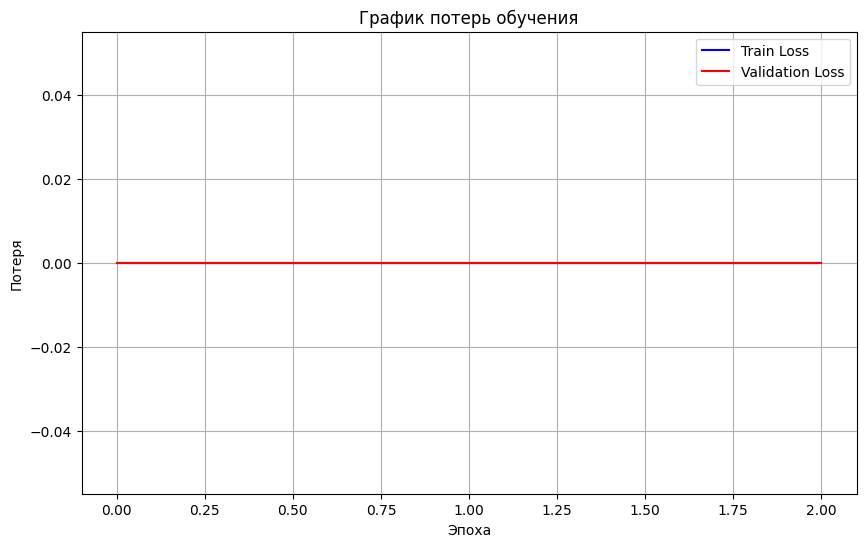

Обучение завершено!


In [42]:
# Start training
trainer = train_model(num_epochs=3)